# BinaryConnect

BinaryConnect: Training Deep Neural Networks with binary weights during propagations

https://arxiv.org/pdf/1511.00363.pdf


notion


https://blue-cannon-bf5.notion.site/BinaryConnect-Training-Deep-Neural-Networks-with-binary-weights-during-propagations-7c70ba20783c4d6eb4621ecdcc7b8df3

CIFAR10 dataset

In [1]:
import os
import numpy as np
import math
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets
from torchvision import models
from torchvision import transforms
from torch.utils.data import DataLoader

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(device, torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print(device)

cuda Tesla P100-PCIE-16GB


In [4]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

In [5]:
config = AttrDict()
config.data_path = '/content/drive/MyDrive/Implement/data'
config.save_path = '/content/drive/MyDrive/Implement/BinaryConnect'
config.dataset = 'CIFAR10'
config.validation_ratio = 0.1
config.img_shape = (3, 32, 32) # CIFAR10
# config.img_shape = (1, 28, 28) # MNIST 
config.augmentation = transforms.Compose([
                        transforms.Resize((config.img_shape[1], config.img_shape[2])),
                        transforms.ToTensor(),
                        transforms.Normalize(mean = [0.5], std = [0.5])
                        ])
config.denormalize = lambda x: x*0.5 + 0.5

config.n_epoch = 100
config.batch_size = 128
config.learning_rate = 1e-5
config.b1 = 0.5
config.b2 = 0.999

## Dataset

In [6]:
if config.dataset == 'MNIST':
    train_dataset = datasets.MNIST(config.data_path,
                                   train = True,
                                   download = True,
                                   )
    test_dataset = datasets.MNIST(config.data_path,
                                   train = False,
                                   download = True,
                                   )
elif config.dataset == 'CIFAR10':
    train_dataset = datasets.CIFAR10(config.data_path,
                                     train = True,
                                     download = True,
                                     transform = config.augmentation
                                     )
    test_dataset = datasets.CIFAR10(config.data_path,
                                     train = False,
                                     download = True,
                                     transform = config.augmentation
                                     )

Files already downloaded and verified
Files already downloaded and verified


In [7]:
class_dict = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [8]:
from torch.utils.data.sampler import SubsetRandomSampler
num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(config.validation_ratio * num_train))

np.random.seed(41)
np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(valid_idx)

train_loader = DataLoader(train_dataset, batch_size = config.batch_size, sampler = train_sampler)
val_loader = DataLoader(train_dataset, batch_size = config.batch_size, sampler = val_sampler)
test_loader = DataLoader(test_dataset, batch_size = config.batch_size, shuffle = True)

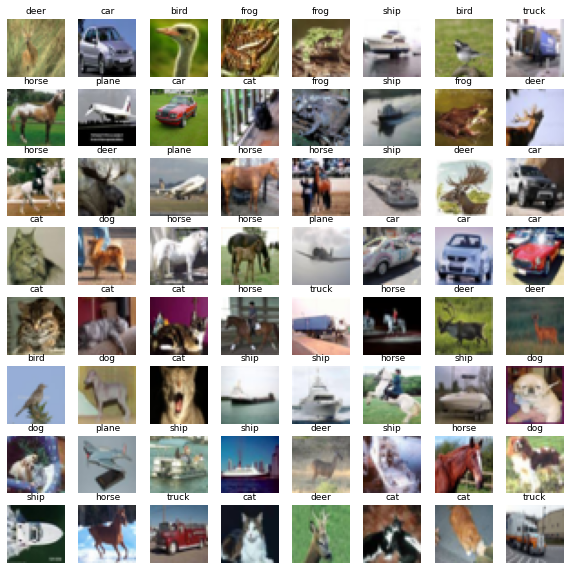

In [9]:
img, label = next(iter(train_loader))
img = config.denormalize(img)

fig = plt.figure(figsize = (10, 10))
for i in range(8):
    for j in range(8):
        plt.subplot(8, 8, 8*i+ j + 1)
        plt.imshow(torchvision.transforms.ToPILImage()(img[8*i+ j]))
        plt.axis('off')
        plt.title(f"{class_dict[label[8*i+j]]}", fontsize = 9)

## Binarized Layer

### Autograd Function

grad_BinarizedConv2d & grad_BinarizedLinear

In [20]:
class grad_binarizedConv2d(torch.autograd.Function):
    """
    forward & backward 별개로 진행됨
    refer: https://pytorch.org/docs/stable/notes/extending.html
           https://github.com/HephaestusProject/pytorch-binaryconnect/blob/master/src/ops/binarized_conv2d.py
    """
    @staticmethod
    def forward(ctx: object, input: torch.Tensor, weight: torch.Tensor, 
                bias = None, stride: int = 1, padding: int = 1, mode:str = "deterministic") -> torch.Tensor:
        """
        args:
            ctx: forward ~ backwawrd 공유 context
            input, weight, bias
            stride, padding
            mode: 'deterministic', 'stochastic' 2가지 방식

            backward 과정에서 autograd graph 사용 X
            => torch.no_grad()로 그래프 구성하지 않음

        """
        with torch.no_grad(): 
            if mode == 'deterministic':
                binarized_weight = weight.sign()
                # 0 -> 1
                binarized_weight[binarized_weight == 0] = 1.0
            elif mode == 'stochastic':
                binary_prob = torch.sigmoid(weight)
                # 0 ~ 1의 uniform prob matrix
                prob_matrix = torch.empty_like(binary_prob).uniform_(0, 1)
                prob_matrix = prob_matrix.to(weight.device)
                binarized_weight = (binary_prob >= prob_matrix).type(torch.float32)
                binarized_weight[binarized_weight == 0] = -1.0
            else:
                raise RuntimeError(f"{mode} not supported")
        
        with torch.no_grad():
            output = F.conv2d(input, binarized_weight, bias,
                              stride, padding)
        
        ctx.save_for_backward(input, binarized_weight, bias)
        ctx.stride = stride
        ctx.padding = padding
        
        return output

    @staticmethod
    def backward(ctx: object, grad_output):
        """
        args:
            ctx
            grad_output: return할 grad_weight

        forward와는 달리 real value를 backprop

        refer: https://github.com/pytorch/pytorch/blob/master/torch/nn/grad.py

        weight: ci, k, k
        input: b, ci, w, h
        output: b, co, w, h
        bias: ci
        """
        # forward에서 (input, binarized_weight, bias)
        input, binarized_weight, bias = ctx.saved_tensors
        stride = ctx.stride
        padding = ctx.padding
        grad_input = grad_weight = grad_bias = None

        with torch.no_grad():
            # (input, binarized_weight, bias)
            if ctx.needs_input_grad[0]:
                # conv2d_input(input_size, weight, grad_output, stride=1, padding=0, dilation=1, groups=1)
                grad_input = torch.nn.grad.conv2d_input(
                    input.shape, binarized_weight, grad_output, stride, padding
                )
                # conv2d_weight(input, weight_size, grad_output, stride=1, padding=0, dilation=1, groups=1)
            if ctx.needs_input_grad[1]:
                grad_weight = torch.nn.grad.conv2d_weight(
                    input, binarized_weight.shape, grad_output, stride, padding
                )
            if bias is not None and ctx.needs_input_grad[2]:
                # 기존 linear 에서는 grad_bias = grad_output.sum(0).squeeze(0) => 1d layer => 3d filter
                 grad_bias = grad_output.sum((0, 2, 3)).squeeze(0)

        # We return as many input gradients as there were arguments.
        # input 개수만큼 return (input, weight, bias, stride, padding, mode)
        return grad_input, grad_weight, grad_bias, None, None, None 
grad_BinarizedConv2d = grad_binarizedConv2d.apply         

In [21]:
class grad_binarizedLinear(torch.autograd.Function):
    """
    conv에서 stride & padding 제거
    refer: https://pytorch.org/docs/stable/notes/extending.html
           https://github.com/HephaestusProject/pytorch-binaryconnect/blob/0a07a524522e993366749a865ae4bdf927cea3b5/src/ops/binarized_linear.py
    """
    @staticmethod
    def forward(ctx: object, input: torch.Tensor, weight: torch.Tensor, 
                bias = None, mode:str = "deterministic") -> torch.Tensor:
        """
        args:
            ctx: forward ~ backwawrd 공유 context
            input, weight, bias
            mode: 'deterministic', 'stochastic' 2가지 방식

            input: b x n
            weight: m x n
            bias: m,
            output: b x m

            backward 과정에서 autograd graph 사용 X
            => torch.no_grad()로 그래프 구성하지 않음
        """
        with torch.no_grad(): 
            if mode == 'deterministic':
                binarized_weight = weight.sign()
                # 0 -> 1
                binarized_weight[binarized_weight == 0] = 1.0
            elif mode == 'stochastic':
                binary_prob = torch.sigmoid(weight)
                # 0 ~ 1의 uniform prob matrix
                prob_matrix = torch.empty_like(binary_prob).uniform_(0, 1)
                prob_matrix = prob_matrix.to(weight.device)
                binarized_weight = (binary_prob >= prob_matrix).type(torch.float32)
                binarized_weight[binarized_weight == 0] = -1.0
            else:
                raise RuntimeError(f"{mode} not supported")

            output = input.mm(binarized_weight.t())
            if bias is not None:
                output += bias.unsqueeze(0).expand_as(output)

        ctx.save_for_backward(input, binarized_weight, bias)
        
        return output

    @staticmethod
    def backward(ctx: object, grad_output):
        """
        args:
            ctx
            grad_output: return할 grad_weight

        grad_input: b x n
        grad_weight: m x n
        grad_bias: m,
        grad_output: b x m

        refer: https://github.com/pytorch/pytorch/blob/master/torch/nn/grad.py
        """
        # forward에서 (input, binarized_weight, bias)
        input, binarized_weight, bias = ctx.saved_tensors
        grad_input = grad_weight = grad_bias = None

        with torch.no_grad():
            # (input, binarized_weight, bias)
            if ctx.needs_input_grad[0]:
                grad_input = grad_output.mm(binarized_weight)
            if ctx.needs_input_grad[1]:
                grad_weight = grad_output.t().mm(input)
            if (bias is not None) and ctx.needs_input_grad[2]:
                 grad_bias = grad_output.sum(0).squeeze(0)

        # We return as many input gradients as there were arguments.
        # input 개수만큼 return (input, weight, bias, mode)
        return grad_input, grad_weight, grad_bias, None

grad_BinarizedLinear = grad_binarizedLinear.apply

### Layer implement

binarizedConv2d, binarizedLinear

In [22]:
class binarizedConv2d(torch.nn.Conv2d):
    """
    BinaryConv2d grad function 이용해서 binarizedConv2d layer 정의
    """
    def __init__(self, in_channels: int, out_channels: int,
                 kernel_size, stride = 1, padding = 1, bias = None, mode = "deterministic"):
        super().__init__(in_channels, out_channels, kernel_size, stride, padding, bias)
        self.stride = stride
        self.padding = padding
        self.mode = mode

    def forward(self, input):
        self.clipping()
        return grad_BinarizedConv2d(
            input, self.weight,
            self.bias, self.stride,
            self.padding, self.mode
        )
    def clipping(self):
        with torch.no_grad():
            self.weight.clamp_(min = -1.0, max=1.0)


In [23]:
class binarizedLinear(torch.nn.Linear):
    def __init__(self, in_features: int, out_features: int,
                 bias = True, mode = "deterministic"):
        super().__init__(in_features, out_features, bias)
        self.mode = mode

    def forward(self, input):
        self.clipping()
        if self.bias is not None:
            return grad_BinarizedLinear(input, self.weight, self.bias)
        return grad_BinarizedLinear(input, self.weight)
        
    def clipping(self):
        with torch.no_grad():
            self.weight.clamp_(min=-1.0, max=1.0)


## Model

### base CNN

**(2x128C3)-MP2-(2x256C3)-MP2-(2x512C3)-MP2-(2x1024FC)-10**

Model: base_cnn & binarized_cnn(mode)

In [24]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size=3, stride = 1, padding=1):
        super().__init__()

        layers = []
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding))
        layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.ReLU())

        self.layers = nn.ModuleList(layers)


    def forward(self, x):
        
        for layer in self.layers:
            x = layer(x)

        return x

In [25]:
class base_cnn(nn.Module):
    def __init__(self):
        super(base_cnn, self).__init__()
        
        self.maxpool = nn.MaxPool2d((2, 2))
        self.conv1 = nn.Sequential(
            ConvBlock(3, 128, 3, 1, 1),
            ConvBlock(128, 128, 3, 1, 1),
            self.maxpool
            )
        self.conv2 = nn.Sequential(
            ConvBlock(128, 256, 3, 1, 1),
            ConvBlock(256, 256, 3, 1, 1),
            self.maxpool
        )
        self.conv3 = nn.Sequential(
            ConvBlock(256, 512, 3, 1, 1),
            ConvBlock(512, 512, 3, 1, 1),
            self.maxpool
        )
        self.fc = nn.Sequential(
            nn.Linear(4*4*512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 10)
        )
        

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.shape[0], -1)
        out = self.fc(x)

        return out

In [26]:
class BinarizedConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size=3, stride = 1,
                 padding = 1, bias = True, mode = "deterministic"):
        super(BinarizedConvBlock, self).__init__()

        layers = []
        layers.append(binarizedConv2d(in_channels, out_channels, kernel_size, stride, padding, bias, mode))
        layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.ReLU())

        self.layers = nn.ModuleList(layers)


    def forward(self, x):
        
        for layer in self.layers:
            x = layer(x)

        return x

In [27]:
class binarized_cnn(nn.Module):
    def __init__(self, mode):
        super(binarized_cnn, self).__init__()

        self.maxpool = nn.MaxPool2d((2, 2))
        self.mode = mode
        self.conv1 = nn.Sequential(
            BinarizedConvBlock(3, 128, 3, 1, 1, True, self.mode),
            BinarizedConvBlock(128, 128, 3, 1, 1, True, self.mode),
            self.maxpool
            )
        self.conv2 = nn.Sequential(
            BinarizedConvBlock(128, 256, 3, 1, 1, True, self.mode),
            BinarizedConvBlock(256, 256, 3, 1, 1, True, self.mode),
            self.maxpool
        )
        self.conv3 = nn.Sequential(
            BinarizedConvBlock(256, 512, 3, 1, 1, True, self.mode),
            BinarizedConvBlock(512, 512, 3, 1, 1, True, self.mode),
            self.maxpool
        )
        self.fc = nn.Sequential(
            binarizedLinear(4*4*512, 1024, True, self.mode),
            nn.ReLU(),
            binarizedLinear(1024, 10, True, self.mode)
        )
        

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.shape[0], -1)
        out = self.fc(x)

        return out

## Training

### base

In [18]:
model_1 = base_cnn().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr = config.learning_rate, betas = (config.b1, config.b2))

In [19]:
# base_cnn
for epoch in tqdm(range(20)):
    print("\nEpoch ", epoch)
    # train
    print("\nTrain:")
    model_1.train()
    train_loss = 0
    for i, (img, label) in enumerate(train_loader): 
        img, label = img.to(device), label.to(device)
        pred = model_1(img)
        loss = criterion(pred, label)    
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if ((i+1) % (len(train_loader) // 3) == 1) or i+1 == len(train_loader):
            print('[%3d/%3d] | Loss: %.5f'%(i+1, len(train_loader), train_loss/(i+1)))
            
    print("\nValidation:")
    with torch.no_grad():
        model_1.eval()
        test_loss = 0
        total = 0
        correct = 0
        for i, (img, label) in enumerate(test_loader):
            img, label = img.to(device), label.to(device)
            pred = model_1(img)
            loss = criterion(pred, label)    
            test_loss += loss.item()

            _, predicted = pred.max(1)
            total += label.size(0)
            correct += predicted.eq(label).sum().item()

            if ((i+1) % (len(test_loader) // 3) == 1) or i+1 == len(test_loader):
                print('[%3d/%3d] | Loss: %.5f'%(i+1, len(test_loader), test_loss/(i+1))) 
            if (i+1) == len(test_loader):
                print(f"Acc: {100.*correct / total:.2f}%")

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch  0

Train:
[  1/176] | Loss: 2.29842
[ 59/176] | Loss: 1.85912
[117/176] | Loss: 1.65824
[175/176] | Loss: 1.54641
[176/176] | Loss: 1.54533

Validation:
[  1/ 40] | Loss: 1.19270
[ 14/ 40] | Loss: 1.25556
[ 27/ 40] | Loss: 1.26095
[ 40/ 40] | Loss: 1.25955
Acc: 55.55%

Epoch  1

Train:
[  1/176] | Loss: 1.24076
[ 59/176] | Loss: 1.19784
[117/176] | Loss: 1.15983
[175/176] | Loss: 1.12680
[176/176] | Loss: 1.12581

Validation:
[  1/ 40] | Loss: 1.17111
[ 14/ 40] | Loss: 1.09426
[ 27/ 40] | Loss: 1.09580
[ 40/ 40] | Loss: 1.09055
Acc: 61.21%

Epoch  2

Train:
[  1/176] | Loss: 0.94454
[ 59/176] | Loss: 0.96590
[117/176] | Loss: 0.94782
[175/176] | Loss: 0.93657
[176/176] | Loss: 0.93638

Validation:
[  1/ 40] | Loss: 1.00633
[ 14/ 40] | Loss: 0.97765
[ 27/ 40] | Loss: 0.96081
[ 40/ 40] | Loss: 0.96237
Acc: 66.02%

Epoch  3

Train:
[  1/176] | Loss: 0.78449
[ 59/176] | Loss: 0.83145
[117/176] | Loss: 0.81719
[175/176] | Loss: 0.81004
[176/176] | Loss: 0.80979

Validation:
[  1/ 40

### binarized model

In [16]:
model_2 = binarized_cnn(mode = 'deterministic').to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr = config.learning_rate, betas = (config.b1, config.b2))

In [17]:
# binarized_cnn
for epoch in tqdm(range(20)):
    print("\nEpoch ", epoch)
    # train
    print("\nTrain:")
    model_2.train()
    train_loss = 0
    for i, (img, label) in enumerate(train_loader): 
        img, label = img.to(device), label.to(device)
        pred = model_2(img)
        loss = criterion(pred, label)    
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if ((i+1) % (len(train_loader) // 3) == 1) or i+1 == len(train_loader):
            print('[%3d/%3d] | Loss: %.5f'%(i+1, len(train_loader), train_loss/(i+1)))
            
    print("\nValidation:")
    with torch.no_grad():
        model_2.eval()
        test_loss = 0
        total = 0
        correct = 0
        for i, (img, label) in enumerate(test_loader):
            img, label = img.to(device), label.to(device)
            pred = model_2(img)
            loss = criterion(pred, label)    
            test_loss += loss.item()

            _, predicted = pred.max(1)
            total += label.size(0)
            correct += predicted.eq(label).sum().item()

            if ((i+1) % (len(test_loader) // 3) == 1) or i+1 == len(test_loader):
                print('[%3d/%3d] | Loss: %.5f'%(i+1, len(test_loader), test_loss/(i+1))) 
            if (i+1) == len(test_loader):
                print(f"Acc: {100.*correct / total:.2f}%")

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch  0

Train:
[  1/352] | Loss: 4459.01465
[118/352] | Loss: 1099.52590
[235/352] | Loss: 896.01670
[352/352] | Loss: 775.00606

Validation:
[  1/ 79] | Loss: 516.84381
[ 27/ 79] | Loss: 486.36151
[ 53/ 79] | Loss: 484.95935
[ 79/ 79] | Loss: 484.56554
Acc: 39.85%

Epoch  1

Train:
[  1/352] | Loss: 337.44177
[118/352] | Loss: 369.94744
[235/352] | Loss: 354.14796
[352/352] | Loss: 337.05846

Validation:
[  1/ 79] | Loss: 292.77942
[ 27/ 79] | Loss: 330.22078
[ 53/ 79] | Loss: 319.85470
[ 79/ 79] | Loss: 325.92704
Acc: 41.54%

Epoch  2

Train:
[  1/352] | Loss: 316.08917
[118/352] | Loss: 228.54407
[235/352] | Loss: 222.43734
[352/352] | Loss: 216.09942

Validation:
[  1/ 79] | Loss: 227.07516
[ 27/ 79] | Loss: 237.40376
[ 53/ 79] | Loss: 231.92588
[ 79/ 79] | Loss: 228.76077
Acc: 43.74%

Epoch  3

Train:
[  1/352] | Loss: 178.06645
[118/352] | Loss: 154.04890
[235/352] | Loss: 155.72377
[352/352] | Loss: 152.86732

Validation:
[  1/ 79] | Loss: 173.32127
[ 27/ 79] | Loss: 180.1580

KeyboardInterrupt: ignored

In [30]:
model_3 = binarized_cnn(mode = 'stochastic').to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr = 1e-6, betas = (config.b1, config.b2))

In [31]:
# binarized_cnn
for epoch in tqdm(range(20)):
    print("\nEpoch ", epoch)
    # train
    print("\nTrain:")
    model_3.train()
    train_loss = 0
    for i, (img, label) in enumerate(train_loader): 
        img, label = img.to(device), label.to(device)
        pred = model_3(img)
        loss = criterion(pred, label)    
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if ((i+1) % (len(train_loader) // 3) == 1) or i+1 == len(train_loader):
            print('[%3d/%3d] | Loss: %.5f'%(i+1, len(train_loader), train_loss/(i+1)))
            
    print("\nValidation:")
    with torch.no_grad():
        model_3.eval()
        test_loss = 0
        total = 0
        correct = 0
        for i, (img, label) in enumerate(test_loader):
            img, label = img.to(device), label.to(device)
            pred = model_3(img)
            loss = criterion(pred, label)    
            test_loss += loss.item()

            _, predicted = pred.max(1)
            total += label.size(0)
            correct += predicted.eq(label).sum().item()

            if ((i+1) % (len(test_loader) // 3) == 1) or i+1 == len(test_loader):
                print('[%3d/%3d] | Loss: %.5f'%(i+1, len(test_loader), test_loss/(i+1))) 
            if (i+1) == len(test_loader):
                print(f"Acc: {100.*correct / total:.2f}%")

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch  0

Train:
[  1/352] | Loss: 3375.39038
[118/352] | Loss: 2161.19708
[235/352] | Loss: 2003.67392
[352/352] | Loss: 1927.71557

Validation:
[  1/ 79] | Loss: 4694.79053
[ 27/ 79] | Loss: 4066.35222
[ 53/ 79] | Loss: 4051.53296
[ 79/ 79] | Loss: 4021.62306
Acc: 10.47%

Epoch  1

Train:
[  1/352] | Loss: 1528.90283
[118/352] | Loss: 1709.72582
[235/352] | Loss: 1677.55969
[352/352] | Loss: 1643.04321

Validation:
[  1/ 79] | Loss: 3598.69409
[ 27/ 79] | Loss: 3578.34469
[ 53/ 79] | Loss: 3764.81964
[ 79/ 79] | Loss: 3744.90617
Acc: 10.55%

Epoch  2

Train:
[  1/352] | Loss: 1584.26514
[118/352] | Loss: 1527.24812
[235/352] | Loss: 1490.80809
[352/352] | Loss: 1459.20456

Validation:
[  1/ 79] | Loss: 3654.67871
[ 27/ 79] | Loss: 3216.39195
[ 53/ 79] | Loss: 3421.89743
[ 79/ 79] | Loss: 3433.93289
Acc: 10.83%

Epoch  3

Train:
[  1/352] | Loss: 1385.53442
[118/352] | Loss: 1352.26107
[235/352] | Loss: 1316.31085
[352/352] | Loss: 1285.88636

Validation:
[  1/ 79] | Loss: 2822.80737

KeyboardInterrupt: ignored